# Part 0: Argument and Import Initialization

- The "Args" class is initialized to contain any pre-defined hyperparameters and variables used in the experiment
- Imports consists of three sections. The fist part titled "Google Colab Imports" is optional and is only used to extract a zip file if the data is loaded as a zip file into google drive - the reason this is done is to unzip the data and load it into the coloab notebooks local memory for efficiency reasons. Otherwise, the data might be read in from the drive image by image during training, which greatly reduces training efficiency. This section can take around 10 minutes to complete.
- Basic torch, pandas, and numpy imports follow, as well as modules necessary to read in and modify the images from the dataset.

In [ ]:
class Args:
    def __init__(self):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.embedding_dim = 128
        self.batch_size = 20
        self.epochs = 50
        self.img_h = 256
        self.img_w = 256
        self.max_caption_length = 20
        self.img_data_path = '/content/drive/MyDrive/Image Caption Generator/data/val2017'
        self.caption_path = '/content/drive/MyDrive/Image Caption Generator/data/captions_val2017.json'

In [ ]:
# 1 GOOGLE COLAB - DATASET IMPORTS
import os
import random
import time

from google.colab import drive
drive.mount('/content/drive')

start_time = time.time()
!unzip -q -u '/content/drive/MyDrive/Image Caption Generator/data/val2017.zip' -d '/content/drive/MyDrive/Image Caption Generator/data'
end_time = time.time()
time_taken = end_time - start_time
print("Time taken:", time_taken/60, "minutes")

# 2 BASIC TORCH IMPORTS
import torch
from torch.utils.data import Dataset, random_split, DataLoader
import torch.nn as nn
import torch.optim as optim
from  torchtext.data.utils import get_tokenizer
import torchvision.models as models
from torchvision import datasets, transforms
import torchtext as tt
import collections

# 3 READING IN IMAGES FROM DATASET
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import zipfile
from io import BytesIO

# 4 TRANSFORMING IMAGES TO DATA
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 5 BUILDING VOCABULARY FROM CAPTIONS
from torchvision.datasets import CocoCaptions
from nltk.tokenize import word_tokenize
from torchtext.vocab import vocab

# 6 INITIALIZE ARGUMENTS
args = Args()

Mounted at /content/drive
Time taken: 1.0881329735120138 minutes


/usr/local/lib/python3.10/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated

# Part 1: Dataset Initilization

- Definite the IMAGE_DATASET class with needed functions. Each image is resized to 64 x 64 pixels, and expanded to 3 channels to ensure consistency in training. The COCO module is used to associate images and image annotations in the COCO dataset.
- Training and Test datasets are initialized from this class as divided originally in the dataset and a DataLoader is initialized
- A vocabulary is also initialized based on the image captions loaded in from the dataset.

In [ ]:
class IMAGE_DATASET(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.coco = COCO(annotations_file)
        self.transform = transform
        self.target_transform = target_transform
        self.img_keys = list(self.coco.imgs.keys())

    def get_single_image(self, img_id):
        # load image and annotations
        img = self.coco.loadImgs(img_id)[0]
        annotation_ids = self.coco.getAnnIds(img_id)
        annotations = self.coco.loadAnns(annotation_ids)

        # open and transform image to tensor with needed dimensions
        path = os.path.join(self.img_dir, img['file_name'])
        image = Image.open(path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        caption = random.choice(annotations)['caption']

        # return image with random annotation choice
        return image, caption

    def __getitem__(self, index):
        img_id = self.img_keys[index]
        return self.get_single_image(img_id)

    def __len__(self):
        return len(self.img_keys)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((args.img_h, args.img_w)),  # Resize the image
    transforms.ToTensor()                         # Convert the image to a tensor
])


# Initialize the full dataset
full_dataset = IMAGE_DATASET(args.caption_path,
                             args.img_data_path,
                             transform)

train_size = int(0.8 * len(full_dataset))  # 80% for training
test_size = len(full_dataset) - train_size  # 20% for testing

image_train, image_test = random_split(full_dataset, [train_size, test_size])

# initialize the data loaders
image_train_loader = DataLoader(dataset=image_train,
                                batch_size=args.batch_size,
                                shuffle=True)
image_test_loader = DataLoader(dataset=image_test,
                               batch_size=args.batch_size,
                               shuffle=False)

# initialize vocabulary
tokenizer = get_tokenizer("basic_english")
counter = collections.Counter()

for ann in full_dataset.coco.anns.values():
    caption = ann['caption'].strip()
    tokens = tokenizer(caption)
    tokens = ['<sos>'] + tokens + ['<eos>']
    counter.update(tokens)

sorted_by_freq = sorted(counter.items(), key=lambda x: x[1], reverse=True)
ordered_dict = collections.OrderedDict(sorted_by_freq)
vocabulary = vocab(ordered_dict)
vocabulary.append_token('<pad>')

loading annotations into memory...
Done (t=0.52s)
creating index...
index created!


# Part 2: Neural Network Initialization
- Two primary layers of the neural network are initialized. First a CNN layer that consists of a VGG-based model
- An LSTM layer that uses the output of the CNN layer with 4096 features as a hidden input, the start token as the input, and passes each generated token as the input in the loop. The sentence is padded or cut at 20 tokens to ensure simplicity and consistency in data size during training.

In [ ]:
# NEURAL NETWORK

class Model(nn.Module):
    def __init__(self, cnn_output_size, vocab_size, embedding_dim, hidden_size):
        super(Model, self).__init__()

        # self.CNN = nn.Sequential(
        #     nn.Conv2d(3, 64, 3, stride=1, padding=1),
        #     nn.ReLU(),
        #     nn.Conv2d(64, 64, 3, stride=1, padding=1),
        #     nn.BatchNorm2d(64),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2, stride=2),
        #     nn.Conv2d(64, 128, 3, stride=1, padding=1),
        #     nn.ReLU(),
        #     nn.Conv2d(128, 128, 3, stride=1, padding=1),
        #     nn.BatchNorm2d(128),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2, stride=2),
        #     nn.Conv2d(128, 256, 3, stride=1, padding=1),
        #     nn.ReLU(),
        #     nn.Conv2d(256, 256, 3, stride=1, padding=1),
        #     nn.BatchNorm2d(256),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2, stride=2),
        #     nn.Conv2d(256, 512, 3, stride=1, padding=1),
        #     nn.ReLU(),
        #     nn.Conv2d(512, 512, 3, stride=1, padding=1),
        #     nn.BatchNorm2d(512),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2, stride=2),
        #     nn.Flatten(),
        #     nn.Linear(8192, 4096),
        #     nn.ReLU(),
        #     nn.Dropout(0.5),
        #     nn.Linear(4096, 4096),
        # )

        vgg = models.vgg16(pretrained=True)
        self.CNN = nn.Sequential(*list(vgg.features.children()))
        for param in self.CNN.parameters():
            param.requires_grad = False

        self.additional_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 8 * 8, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096)
        )

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.LSTM = nn.LSTM(embedding_dim, hidden_size, batch_first = True)
        self.attention = nn.Linear(hidden_size, hidden_size)
        self.FC = nn.Linear(hidden_size, vocab_size)
        self.FC_CNN = nn.Linear(cnn_output_size, hidden_size)

        self.cnn_output_size = cnn_output_size
        self.hidden_size = hidden_size

    def forward(self, x, captions = None):
        with torch.no_grad():
            cnn_features = self.CNN(x)

        cnn_features = self.additional_layers(cnn_features)
        h_i = self.FC_CNN(cnn_features)
        c_i = torch.zeros_like(h_i).to(args.device)

        if captions is None:
          # INFERENCE MODE:
          captions = []
          current_word = torch.zeros((args.batch_size, 1), dtype=torch.long, device=args.device)

          for _ in range(20):
            embed = self.embedding(current_word)
            output, (h_i, c_i) = self.LSTM(embed, (h_i, c_i))
            logits = self.FC(output.squeeze(1))
            _, predicted_word = logits.max(1)
            captions.append(predicted_word.unsqueeze(1))
            current_word = predicted_word.unsqueeze(1)

          captions = torch.cat(captions, 1)

          return captions
        else:
            # Training mode:
            embed = self.embedding(captions)
            embed = torch.cat((torch.zeros(args.batch_size, 1, embed.size(2), device=args.device), embed[:, :-1, :]), dim=1)
            lstm_out, _ = self.LSTM(embed, (h_i.unsqueeze(0), c_i.unsqueeze(0)))
            logits = self.FC(lstm_out)

            return logits




In [ ]:
# INITIALIZE NETWORK
device = args.device
lstm = Model(4096, len(vocabulary), 512, 4096)
lstm = lstm.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 89.8MB/s]


# Part 3: Training

This part consists of the primary training loop over the desired number of epochs and specified batch size. The labels are tokenized, padded / shortened as needed, and the <sos> and <eos> tokens are added. The CNN output is then fed into the LSTM and a backpropagation is used based on the loss.

Using device cpu


KeyboardInterrupt: 

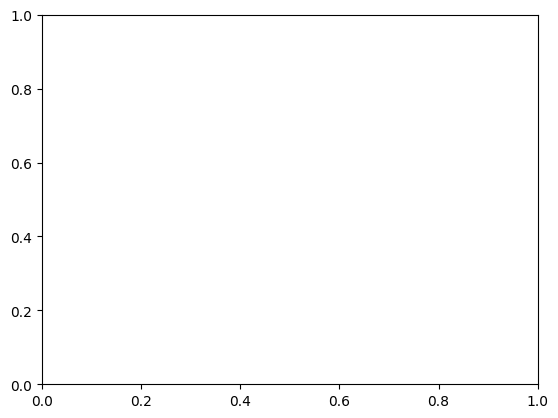

In [ ]:
# TRAINING
print('Using device {}'.format(device))

tokenizer = tt.data.utils.get_tokenizer("basic_english")
loss_func = nn.CrossEntropyLoss(ignore_index = vocabulary['<pad>']).cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss(ignore_index = vocabulary['<pad>'])

optimizer = optim.Adam(lstm.parameters(), lr=0.0005, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

def pad_sequences(sequences, max_length, pad_token='<pad>'):
    return [seq + [pad_token] * (max_length - len(seq)) if len(seq) < max_length else seq[:max_length] for seq in sequences]

def tokenize_and_pad(labels, vocab, max_length=20):
    tokenized_labels = [['<sos>'] + tokenizer(label) + ['<eos>'] for label in labels]
    tokenized_labels = pad_sequences(tokenized_labels, max_length)
    indexed_labels = [[vocab[token] for token in seq] for seq in tokenized_labels]
    return indexed_labels

def train(num_epochs):
    train_losses = []

    plt.ion()
    fig, ax = plt.subplots()

    for idx_e in range(num_epochs):

        lstm.train()

        for idx, batch in enumerate(image_train_loader):

            DATA, LABELS = batch

            # Tokenize and pad labels
            tokenized_labels = tokenize_and_pad(LABELS, vocabulary)

            # Convert to tensor
            target_sequences = torch.tensor(tokenized_labels, dtype=torch.long).to(device)

            # Get LSTM predictions
            pred = lstm(DATA.to(device), target_sequences)

            pred_loss = pred.view(-1, pred.size(-1))

            target_sequences_loss = target_sequences.view(-1)

            # Calculate loss
            loss = loss_func(pred_loss, target_sequences_loss)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(lstm.parameters(), max_norm=1.0)
            optimizer.step()

            train_losses.append(loss.item())

            if idx % 10 == 0:
                # PRINT EPOCH + LOSS INFO
                print(f'Epoch [{idx_e+1}/{num_epochs}], Step [{idx+1}/{len(image_train_loader)}], Loss: {loss.item():.4f}')

                ax.clear()
                ax.plot(train_losses, label='Training Loss')
                ax.set_xlabel('Iterations')
                ax.set_ylabel('Loss')
                ax.legend()
                fig.canvas.draw()
                plt.pause(0.1)

                # PRINT SAMPLE SENTENCE:
                probabilities = torch.softmax(pred[0], dim=-1)
                predicted_indices = torch.argmax(probabilities, dim=-1)
                predicted_tokens = vocabulary.lookup_tokens(predicted_indices.tolist())
                print(predicted_tokens, vocabulary.lookup_tokens(target_sequences[0].tolist()))

        scheduler.step()

    plt.ioff()
    plt.show()

train(50)

In [ ]:
lstm.eval()

for idx, batch in enumerate(image_train_loader):
            DATA, LABELS = batch

            # Tokenize and pad labels
            tokenized_labels = tokenize_and_pad(LABELS, vocabulary)

            # Convert to tensor
            target_sequences = torch.tensor(tokenized_labels, dtype=torch.long).to(device)

            # Get CNN output
            cnn_output = cnn(DATA.to(device))

            # Get LSTM predictions
            pred = lstm(cnn_output)





            break

# Part 4: Testing, Validation, and Analysis

In [ ]:
def get_accuracy():
  pass

def sample():
  pass

get_accuracy()
sample()

# Part 5: Export Model

In [ ]:
torch.save(cnn.state_dict(), '/content/drive/MyDrive/Image Caption Generator/model')
torch.save(lstm.state_dict(), '/content/drive/MyDrive/Image Caption Generator/model')
